In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re
import math
import seaborn as sns
from collections import OrderedDict 

In [2]:
# read file ktotal
df_ktotal = pd.read_csv('ktotal_contratos.csv')
# clean data
### format col names 
df_ktotal.columns = df_ktotal.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_ktotal = df_ktotal[['cct_id', 'cct_ctl_id','cct_warranty_start_date', 'cct_hiring_date', 'cct_contract_source', 
                       'cct_plan_id', 'cct_contract_status_id']]
df_ktotal = df_ktotal.rename(columns={'cct_id':'ktot_id','cct_ctl_id': 'stockid', 'cct_warranty_start_date':'date_delivery', 
                                      'cct_hiring_date':'date_activation', 
                                      'cct_contract_source':'source', 'cct_plan_id':'payment'})
### format date delivery col
df_ktotal['date_delivery'] = pd.to_datetime(df_ktotal['date_delivery'])
### format date activation col
df_ktotal['date_activation'] = pd.to_datetime(df_ktotal['date_activation']).dt.date
### sort, filter by, and format stockid
df_ktotal = df_ktotal.sort_values('date_delivery', ascending=False)
df_ktotal = df_ktotal.drop_duplicates('stockid')
df_ktotal['stockid'] = df_ktotal['stockid'].astype(int)
# examine data
print(df_ktotal.shape)
df_ktotal.head()

(2302, 7)


,ktot_id,stockid,date_delivery,date_activation,source,payment,cct_contract_status_id
660,2315,28135,2020-12-24,2020-12-10,3,0,1
646,2349,30103,2020-12-22,2020-12-12,3,0,1
484,2341,29681,2020-12-17,2020-12-11,3,0,1
325,2297,25929,2020-12-17,2020-12-08,2,1,1
772,2359,27900,2020-12-16,2020-12-12,3,0,1


In [3]:
# ktotal: cancelled contracts in current month
### find current month and year 
curr_month = pd.to_datetime(datetime.date(datetime.now())).month
curr_year = pd.to_datetime(datetime.date(datetime.now())).year
### add month and year cols
df_ktotal['month'] = df_ktotal['date_delivery'].dt.month
df_ktotal['year'] = df_ktotal['date_delivery'].dt.year
### exclude cancelled contracts
ids = df_ktotal[(df_ktotal['cct_contract_status_id']==3) & (df_ktotal['month']== curr_month) &
                (df_ktotal['year']==curr_year)]['ktot_id'].values
ids

array([2118, 2203])

In [4]:
# ktotal: payment history
df_ktotpay = pd.read_csv('ktotal_payments.csv')
df_ktotpay = df_ktotpay.rename(columns={'cph_cct_id':'ktot_id'})
df_ktotpay[df_ktotpay['ktot_id'].isin(ids)]

,cph_id,ktot_id,cph_obl_id,cph_payment_number,cph_payment_amount,cph_start_date,cph_end_date,cph_payment_next_date,cph_payment_status,cph_is_send_netsuite,cph_send_netsuite_date,cph_is_put_netsuite,cph_is_active,cph_creation_date,cph_last_update,cph_netsuite_int_id,cph_price_id


In [5]:
# ktotal: remove all cancelled contracts?
df_ktotal = df_ktotal[df_ktotal['cct_contract_status_id']!=3]

In [6]:
# read file kcapital
df_kcapital = pd.read_csv("kcapital_contratos.csv")
# clean data
### clean col names
df_kcapital.columns = df_kcapital.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### format date col
df_kcapital['dia_solicitud_aprobada'] = pd.to_datetime(df_kcapital['dia_solicitud_aprobada'], dayfirst=True)
### only include cars with kcapital
df_kcapital =  df_kcapital[df_kcapital['financiamiento_ganado'] == 'Yes']
### select and rename relevant cols
df_kcapital = df_kcapital[['stock_id','dia_solicitud_aprobada']]
df_kcapital = df_kcapital.rename(columns={'dia_solicitud_aprobada': 'date_approved', 'stock_id':'stockid'})
### format stockid col
df_kcapital['stockid'] = df_kcapital['stockid'].astype(int)
### sort and filter by stockid
df_kcapital = df_kcapital.sort_values('date_approved', ascending=False)
df_kcapital = df_kcapital.drop_duplicates('stockid')
# examine data
print(df_kcapital.shape)
df_kcapital.head()

(1445, 2)


,stockid,date_approved
3592,28342,2020-12-14
3587,29838,2020-12-14
3631,24415,2020-12-12
3590,22889,2020-12-12
3503,26282,2020-12-11


In [7]:
# read file entregas
df_entregas = pd.read_csv("entregas.csv")
# clean data
### format col names
df_entregas.columns = df_entregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_entregas = df_entregas[['estimate_asociado','auto', 'fecha_de_entrega_agendada',
                           'hora', "tipo_de_lugar_destino", 'responsable_em_venta']]
df_entregas = df_entregas.rename(columns={'estimate_asociado': 'estimate', 'auto':'stockid', 
                                          'fecha_de_entrega_agendada':'date_delivery', 'hora':'hour', 
                                          'tipo_de_lugar_destino':'hub',
                                          "responsable_em_venta":'salesperson'})
### format, filter by, and sort by date col
df_entregas['date_delivery'] = pd.to_datetime(df_entregas['date_delivery'],  dayfirst=True)
min_date = df_ktotal['date_delivery'].min()
df_entregas = df_entregas[df_entregas['date_delivery'] >= min_date]
df_entregas = df_entregas.sort_values('date_delivery', ascending=False)
### format and filter by stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_entregas['stockid'] = df_entregas['stockid'].apply(extr_stockid)
df_entregas = df_entregas.drop_duplicates('stockid')
### format estimate col
df_entregas['estimate'] = df_entregas['estimate'].str[10:]
# examine data
print(df_entregas.shape)
df_entregas.head()

(9398, 6)


,estimate,stockid,date_delivery,hour,hub,salesperson
13825,3588354,28135,2020-12-24,14:00,CASA CLIENTE,Mariana Contreras Castillo
13824,3521022,19935,2020-12-23,16:00,HQ - GUADALAJARA,Jessica Gonzalez
13823,3587607,23402,2020-12-23,12:00,GDL - MIDTOWN,Carlos Vigueras
13822,3566524,24443,2020-12-23,12:00,MTY - FASHION DRIVE,Jessica Gonzalez
13821,3580349,30010,2020-12-22,15:45,FLORENCIA,Kathia Gonzalez


In [8]:
# remove uncompleted "deliveries"
df_ventregas = pd.read_csv('ventregas.csv')
# clean data
### format col names
df_ventregas.columns = df_ventregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_ventregas = df_ventregas[['estimate','stock_id', 'fecha_entrega_espejo']]
df_ventregas = df_ventregas.drop_duplicates()
df_ventregas = df_ventregas[-(df_ventregas['fecha_entrega_espejo'].isnull())]
print("shape entregas")
print(df_entregas.shape)
print('\n')
indcs = np.zeros(len(df_entregas))
for i in range(len(df_entregas)):
    if (isinstance(df_entregas['estimate'].iloc[i], float)): 
        print(i)
    elif (int(df_entregas['estimate'].iloc[i]) in list(df_ventregas['estimate'].values)):
        indcs[i] = 1
df_entregas = df_entregas.iloc[indcs==1]
print('\n')
print("shape entregas")
print(df_entregas.shape)
df_entregas.head()

shape entregas
(9398, 6)


1443
1454
7652


shape entregas
(8871, 6)


,estimate,stockid,date_delivery,hour,hub,salesperson
13635,3648222,23102,2020-12-14,12:00,MTY - FASHION DRIVE,Jaime Ronaldo Robles Aleman
13631,3581298,24219,2020-12-14,12:00,MTY - FASHION DRIVE,Rodolfo Ivan Flores Alardin
13697,3341054,27500,2020-12-14,17:15,GDL - MIDTOWN,Jessica Gonzalez
13598,3186964,26472,2020-12-13,10:00,WH - LERMA,Kimberly Pantoja
13599,2841882,21318,2020-12-13,10:00,PLAZA FORTUNA,German Velasco


In [ ]:
# take into account deliveries at CASA CLIENTE
### read em file
ems = pd.read_csv('ems.csv')
### keep and rename relevant cols
ems = ems[['reponsable_em_venta', 'centro_del_em']]
ems = ems.rename(columns={'centro_del_em': 'hub', "reponsable_em_venta":'salesperson'})
### match salespeople with hub
hub_em = ["" for x in range(len(df_entregas))]
for i in range(len(df_entregas)):
    if df_entregas['salesperson'].iloc[i] in list(ems['salesperson'].values):
        indx = list(ems['salesperson'].values).index(df_entregas['salesperson'].iloc[i])
        hub_em[i] = ems['hub'].iloc[indx]
    else: hub_em[i] = 'Sin asignar'
df_entregas['hub_em'] = hub_em
### correct CASA CLIENTE
for i in range(len(df_entregas)):
    if (df_entregas['hub'].iloc[i]  == 'CASA CLIENTE'):
        df_entregas['hub'].iloc[i] =  df_entregas['hub_em'].iloc[i]
    if ((df_entregas['hub'].iloc[i] == 'WH - LERMA') or (df_entregas['hub'].iloc[i] == 'HQ - LERMA')):
        df_entregas['hub'].iloc[i] = 'LERMA'
    if (df_entregas['hub'].iloc[i] == 'MTY - FASHION DRIVE'):
        df_entregas['hub'].iloc[i] = 'MONTERREY'
    if (df_entregas['hub'].iloc[i] == 'HQ - GUADALAJARA'):
        df_entregas['hub'].iloc[i] = 'GDL - HQ'
    if (df_entregas['hub'].iloc[i] == 'ESTADO DE MEXICO - INTERLOMAS'):
        df_entregas['hub'].iloc[i] = 'INTERLOMAS'
### examine updated df
print(df_entregas.shape)
df_entregas.head()

In [ ]:
# transform entregas to include ktotal, activtion date, and tradein cols
ktotal = np.zeros(len(df_entregas), dtype=int)
tradein = np.zeros(len(df_entregas), dtype=int)
date_act = np.zeros(len(df_entregas), dtype=datetime)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_ktotal['stockid'].values):
        ktotal[i] = 1
        indx = list(df_ktotal['stockid'].values).index(int(df_entregas['stockid'].iloc[i]))
        date_act[i] = df_ktotal['date_activation'].iloc[indx]
        if(df_ktotal['source'].iloc[indx]==3): tradein[i] = 1                                                     
df_entregas['ktotal'] = ktotal
df_entregas['tradein'] = tradein
df_entregas['ktotal_activation'] = date_act
print(sum(df_entregas['ktotal'] == 1))
print(sum(df_entregas['tradein'] == 1))
df_entregas.head()

In [ ]:
# transform entregas to include kcapital col
kcapital = np.zeros(len(df_entregas), dtype=int)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_kcapital['stockid'].values):
        kcapital[i] = 1
df_entregas['kcapital'] = kcapital
print(sum(df_entregas['kcapital'] == 1))
df_entregas.head()

In [ ]:
# transform entregas to include city col
city = ["" for x in range(len(df_entregas))]
hubs_cities = {'CDMX':['SANTA FE','SAN ANGEL', 'PLAZA FORTUNA', 'PATIO TLALPAN','LERMA', 'INTERLOMAS', 'FLORENCIA'],
              'PUEBLA':'PUE - EXPLANADA', 'GUADALAJARA':['GDL - MIDTOWN', 'GDL - HQ']}
for i in range(len(df_entregas)):
    if(df_entregas['hub'].iloc[i] in hubs_cities['CDMX']): city[i] = 'CDMX'
    elif(df_entregas['hub'].iloc[i] in hubs_cities['PUEBLA']): city[i] = 'PUEBLA'
    elif(df_entregas['hub'].iloc[i] in hubs_cities['GUADALAJARA']): city[i] = 'GUADALAJARA'
    else: city[i] = 'MONTERREY' 
df_entregas['city'] = city
df_entregas.head()

In [ ]:
### transform entregas to include month-year col
month_yr = [0] * len(df_entregas)
for i in range(len(df_entregas)):
    month_yr[i] = str(df_entregas['month'].iloc[i]) + '-' + str(df_entregas['year'].iloc[i])  
df_entregas['month_yr'] = month_yr
df_entregas.head()

In [ ]:
# export df
#df_entregas.to_csv('entregas_clean.csv')

In [ ]:
# GRAPH 1: 15 DAYS
# calculations
# cols 1-2
### find last 15 days
ayer = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=1))
hace_quince = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=15))
curr_days = pd.date_range(hace_quince, periods=15)
### filter data for curr days
df_curr_day = df_entregas[df_entregas['date_delivery'].isin(curr_days)]
### initialize dics
daily_entregas = OrderedDict() 
daily_ktotal = OrderedDict() 
daily_ti = OrderedDict()
### find num of entregas, ktotal, and tradeins
for hub, frame in df_curr_day.groupby(['hub']):
    if (hub == 'Sin asignar'): 
        print(frame)
    daily_entregas[hub] = len(frame)
    daily_ktotal[hub] = sum(frame['ktotal']==1)
    daily_ti[hub] = sum(frame['tradein']==1)
### find overalls
daily_entregas['OVERALL'] = len(df_curr_day)
daily_ktotal['OVERALL'] = sum(df_curr_day['ktotal']==1)
daily_ti["OVERALL"] = sum(df_curr_day['tradein']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas.keys()):
    daily_entregas.pop('Sin asignar')
x_entr = daily_entregas.keys()
y_entr = [float(i) for i in daily_entregas.values()] 
### 1: set x and y values: ktotal 
if ('Sin asignar' in daily_ktotal.keys()):
    daily_ktotal.pop('Sin asignar')
x_ktot = daily_ktotal.keys()
y_ktot = [float(i) for i in daily_ktotal.values()] 
y_ktot_pr = [i / j for i, j in zip(y_ktot, y_entr)]
### 2: set x and y values: tradeins
if ('Sin asignar' in daily_ti.keys()):
    daily_ti.pop('Sin asignar')
x_ti = daily_ti.keys()
y_ti = [float(i) for i in daily_ti.values()] 
y_ti_pr = [i / j for i, j in zip(y_ti, y_entr)]

In [ ]:
# GRAPH 1: 15 DAYS
# col 3
### exclude trade-ins
df_curr_day_noti = df_curr_day[df_curr_day['tradein']==0]
### initialize dics
daily_entregas_noti = OrderedDict()
daily_kcap_noti = OrderedDict()
### find num of entregas, kcapital
for hub, frame in df_curr_day_noti.groupby(['hub']):
    daily_entregas_noti[hub] = len(frame)
    daily_kcap_noti[hub] = sum(frame['kcapital']==1)
### find overalls
daily_entregas_noti['OVERALL'] = len(df_curr_day_noti)
daily_kcap_noti['OVERALL'] = sum(df_curr_day_noti['kcapital']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas_noti.keys()):
    daily_entregas_noti.pop('Sin asignar')
x_entr_noti = daily_entregas_noti.keys()
y_entr_noti = [float(i) for i in daily_entregas_noti.values()] 
### 3: set x and y values: kcapital 
if ('Sin asignar' in daily_kcap_noti.keys()):
    daily_kcap_noti.pop('Sin asignar')
x_kcap_noti = daily_kcap_noti.keys()
y_kcap_noti = [float(i) for i in daily_kcap_noti.values()] 
y_kcap_noti_pr = [i / j for i, j in zip(y_kcap_noti, y_entr_noti)]

In [ ]:
# GRAPH 1: 15 DAYS
# col 4
### consider only kcapital (excluding trade-ins)
df_curr_day_kcap = df_curr_day[(df_curr_day['kcapital']==1) & (df_curr_day['tradein']==0)]
### initialize dics
daily_entregas_kcap = OrderedDict()
daily_ktot_kcap = OrderedDict()
### find num of entregas, kcapital
for hub, frame in df_curr_day_kcap.groupby(['hub']):
    daily_entregas_kcap[hub] = len(frame)
    daily_ktot_kcap[hub] = sum(frame['ktotal']==1)
### find overalls
daily_entregas_kcap['OVERALL'] = len(df_curr_day_kcap)
daily_ktot_kcap['OVERALL'] = sum(df_curr_day_kcap['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas_kcap.keys()):
    daily_entregas_kcap.pop('Sin asignar')
x_entr_kcap = daily_entregas_kcap.keys()
y_entr_kcap = [float(i) for i in daily_entregas_kcap.values()] 
### set x and y values: kcapital 
if ('Sin asignar' in daily_ktot_kcap.keys()):
    daily_ktot_kcap.pop('Sin asignar')
x_ktot_kcap = daily_ktot_kcap.keys()
y_ktot_kcap = [float(i) for i in daily_ktot_kcap.values()] 
y_ktot_kcap_pr = [i / j for i, j in zip(y_ktot_kcap, y_entr_kcap)]

In [ ]:
# GRAPH 1: 15 DAYS
# col 5
### exclude trade-ins and kcapital
df_noti_nkcap = df_curr_day[(df_curr_day['tradein']==0) & (df_curr_day['kcapital']==0)]
### initialize dics
noti_nkcap = OrderedDict()
ktot_noti_nkcap = OrderedDict()
### find num of entregas, ktotal
for hub, frame in df_noti_nkcap.groupby(['hub']):
    noti_nkcap[hub] = len(frame)
    ktot_noti_nkcap[hub] = sum(frame['ktotal']==1)
### find overalls
noti_nkcap['OVERALL'] = len(df_noti_nkcap)
ktot_noti_nkcap['OVERALL'] = sum(df_noti_nkcap['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in noti_nkcap.keys()):
    noti_nkcap.pop('Sin asignar')
x_enoti_nkcap = noti_nkcap.keys()
y_enoti_nkcap = [float(i) for i in noti_nkcap.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ktot_noti_nkcap.keys()):
    ktot_noti_nkcap.pop('Sin asignar')
x_ktot_ntikc = ktot_noti_nkcap.keys()
y_ktot_ntikc = [float(i) for i in ktot_noti_nkcap.values()] 
y_ktot_ntikc_pr = [i / j for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]

In [ ]:
# GRAPH 1: 15 DAYS
# plot figure with 5 cols
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(50)
### 1
bar1g = ax1.barh(x_ktot, [1] * len(x_ktot), alpha=.4, color="gray")
bar1 = ax1.barh(x_ktot, y_ktot_pr, alpha=.6, color="royalblue")
ax1.set_title('Overall Conversion', fontsize=40)
ax1.set_yticklabels(x_ktot, va='bottom', fontsize=25)
### 2
bar2g = ax2.barh(x_ti, [1] * len(x_ti), alpha=.4, color="gray")
bar2 = ax2.barh(x_ti, y_ti_pr, alpha=.4, color="royalblue")
ax2.set_title('Trade-in / Deliveries', fontsize=40)
ax2.set_yticklabels(x_ti, va='bottom', fontsize=25)
### 3
bar3g = ax3.barh(x_kcap_noti, [1] * len(x_kcap_noti), alpha=.4, color="gray")
bar3 = ax3.barh(x_kcap_noti, y_kcap_noti_pr, alpha=.4, color="royalblue")
ax3.set_title('Kavak Capital / Deliveries \n (excluding trade-ins)', fontsize=37)
ax3.set_yticklabels(x_kcap_noti, va='bottom', fontsize=25)
### 4
bar4g = ax4.barh(x_ktot_kcap, [1] * len(x_ktot_kcap), alpha=.4, color="gray")
bar4 = ax4.barh(x_ktot_kcap, y_ktot_kcap_pr, alpha=.4, color="royalblue")
ax4.set_title('Kavak Total / Kavak Capital \n (excluding trade-ins)', fontsize=37)
ax4.set_yticklabels(x_ktot_kcap, va='bottom', fontsize=25)
### 5
bar5g = ax5.barh(x_ktot_ntikc, [1] * len(x_ktot_ntikc), alpha=.4, color="gray")
bar5 = ax5.barh(x_ktot_ntikc, y_ktot_ntikc_pr, alpha=.4, color="royalblue")
ax5.set_title('Purchase in app / Deliveries \n (excluding trade-in and Kavak Capital)', fontsize=37)
ax5.set_yticklabels(x_ktot_ntikc, va='bottom', fontsize=25)
# format axes, title, and labels
### axes
for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
plt.rc('ytick', labelsize=30) 
plt.subplots_adjust(wspace = 0.85)
### title
titlestr = ('Kavak Total conversion by hub: ' + hace_quince.strftime('%d/%m/%Y') + '-' + 
           ayer.strftime('%d/%m/%Y'))
fig.suptitle(titlestr, fontsize=50, fontname="Arial");
### labels
##### 1
for idx,rect in enumerate(bar1):
    if (y_ktot[idx] != 0):
        ax1.text(y_ktot_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ktot[idx]) != 0):
        ax1.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax1.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 2
for idx,rect in enumerate(bar2):
    if (y_ti[idx] != 0):
        ax2.text(y_ti_pr[idx]+.05, rect.get_y()+.35,
            int(y_ti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ti[idx]) != 0):
        ax2.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax2.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ti_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0) 
##### 3
for idx,rect in enumerate(bar3):
    if (y_kcap_noti[idx] != 0):
        ax3.text(y_kcap_noti_pr[idx]+.05, rect.get_y()+.35,
            int(y_kcap_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_noti[idx]-y_kcap_noti[idx]) != 0):
        ax3.text(1+.05, rect.get_y()+.35,
            int(y_entr_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax3.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_kcap_noti_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 4
for idx,rect in enumerate(bar4):
    if (y_ktot_kcap[idx] != 0):
        ax4.text(y_ktot_kcap_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_kcap[idx]-y_ktot_kcap[idx]) != 0):
        ax4.text(1+.05, rect.get_y()+.35,
            int(y_entr_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax4.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_kcap_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 5
for idx,rect in enumerate(bar5):
    if (y_ktot_ntikc[idx] != 0):
        ax5.text(y_ktot_ntikc_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_ntikc[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_enoti_nkcap[idx]-y_ktot_ntikc[idx]) != 0):
        ax5.text(1+.05, rect.get_y()+.35,
            int(y_enoti_nkcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax5.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_ntikc_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
# save fig
#plt.savefig('hub_performance_15d.png') 

In [ ]:
# GRAPH 2: MTD
# calculations
# cols 1-2
### handle div by zero
def check_den(n, d):
    return n / d if d else 0
### add month and year cols
df_entregas['month'] = df_entregas['date_delivery'].dt.month
df_entregas['year'] = df_entregas['date_delivery'].dt.year
### find curr month and year 
curr_month = pd.to_datetime(datetime.date(datetime.now())).month
curr_year = pd.to_datetime(datetime.date(datetime.now())).year
### include only curr month
df_curm = df_entregas[(df_entregas['month'] == curr_month) & (df_entregas['year'] == curr_year)]
### initialize dics
nombres_hubs = ['SANTA FE', 'SAN ANGEL', 'PUE - EXPLANADA', 'PLAZA FORTUNA', 'PATIO TLALPAN', 'MONTERREY', 
                'LERMA', 'INTERLOMAS', 'GDL - MIDTOWN', 'GDL - HQ', 'FLORENCIA', 'OVERALL']
month_entregas = OrderedDict()
for i in nombres_hubs:
    month_entregas[i] = 0
month_ktotal = OrderedDict()
for i in nombres_hubs:
    month_ktotal[i] = 0
month_ti = OrderedDict()
for i in nombres_hubs:
    month_ti[i] = 0
### find num of entregas, ktotal, and tradeins
for hub, frame in df_curm.groupby(['hub']):
    if (hub == 'Sin asignar'): 
        print(frame)
    month_entregas[hub] = len(frame)
    month_ktotal[hub] = sum(frame['ktotal']==1)
    month_ti[hub] = sum(frame['tradein']==1)
### find overalls
month_entregas['OVERALL'] = len(df_curm)
month_ktotal['OVERALL'] = sum(df_curm['ktotal']==1)
month_ti["OVERALL"] = sum(df_curm['tradein']==1)
### set x and y values: entregas 
if ('Sin asignar' in month_entregas.keys()):
    month_entregas.pop('Sin asignar')
x_entr = month_entregas.keys()
y_entr = [float(i) for i in month_entregas.values()] 
### 1: set x and y values: ktotal 
if ('Sin asignar' in month_ktotal.keys()):
    month_ktotal.pop('Sin asignar')
x_ktot = month_ktotal.keys()
y_ktot = [float(i) for i in month_ktotal.values()] 
y_ktot_pr = [check_den(i, j) for i, j in zip(y_ktot, y_entr)]
### 2: set x and y values: tradeins
if ('Sin asignar' in month_ti.keys()):
    month_ti.pop('Sin asignar')
x_ti = month_ti.keys()
y_ti = [float(i) for i in month_ti.values()] 
y_ti_pr = [check_den(i, j) for i, j in zip(y_ti, y_entr)]

In [ ]:
# GRAPH 2: MTD
# col 3
### exclude trade-ins
df_curr_month_noti = df_curm[df_curm['tradein']==0]
### initialize dics
month_entregas_noti = OrderedDict()
for i in nombres_hubs:
    month_entregas_noti[i] = 0
month_kcap_noti = OrderedDict()
for i in nombres_hubs:
    month_kcap_noti[i] = 0
### find num of entregas, kcapital
for hub, frame in df_curr_month_noti.groupby(['hub']):
    month_entregas_noti[hub] = len(frame)
    month_kcap_noti[hub] = sum(frame['kcapital']==1)
### find overalls
month_entregas_noti['OVERALL'] = len(df_curr_month_noti)
month_kcap_noti['OVERALL'] = sum(df_curr_month_noti['kcapital']==1)
### set x and y values: entregas 
if ('Sin asignar' in month_entregas_noti.keys()):
    month_entregas_noti.pop('Sin asignar')
x_entr_noti = month_entregas_noti.keys()
y_entr_noti = [float(i) for i in month_entregas_noti.values()] 
### 3: set x and y values: kcapital 
if ('Sin asignar' in month_kcap_noti.keys()):
    month_kcap_noti.pop('Sin asignar')
x_kcap_noti = month_kcap_noti.keys()
y_kcap_noti = [float(i) for i in month_kcap_noti.values()] 
y_kcap_noti_pr = [check_den(i, j) for i, j in zip(y_kcap_noti, y_entr_noti)]

In [ ]:
# GRAPH 2: MTD
# col 4
### consider only kcapital (excluding trade-ins)
df_curr_month_kcap = df_curm[(df_curm['kcapital']==1) & (df_curm['tradein']==0)]
### initialize dics
month_entregas_kcap = OrderedDict()
for i in nombres_hubs:
    month_entregas_kcap[i] = 0
month_ktot_kcap = OrderedDict()
for i in nombres_hubs:
    month_ktot_kcap[i] = 0
### find num of entregas, kcapital
for hub, frame in df_curr_month_kcap.groupby(['hub']):
    month_entregas_kcap[hub] = len(frame)
    month_ktot_kcap[hub] = sum(frame['ktotal']==1)
### find overalls
month_entregas_kcap['OVERALL'] = len(df_curr_month_kcap)
month_ktot_kcap['OVERALL'] = sum(df_curr_month_kcap['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in month_entregas_kcap.keys()):
    month_entregas_kcap.pop('Sin asignar')
x_entr_kcap = month_entregas_kcap.keys()
y_entr_kcap = [float(i) for i in month_entregas_kcap.values()] 
### set x and y values: kcapital 
if ('Sin asignar' in month_ktot_kcap.keys()):
    month_ktot_kcap.pop('Sin asignar')
x_ktot_kcap = month_ktot_kcap.keys()
y_ktot_kcap = [float(i) for i in month_ktot_kcap.values()] 
y_ktot_kcap_pr = [check_den(i, j) for i, j in zip(y_ktot_kcap, y_entr_kcap)]

In [ ]:
# GRAPH 2: MTD
# col 5
### exclude trade-ins and kcapital
dfm_noti_nkcap = df_curm[(df_curm['tradein']==0) & (df_curm['kcapital']==0)]
### initialize dics
notim_nkcap = OrderedDict()
for i in nombres_hubs:
    notim_nkcap[i] = 0
ktotm_noti_nkcap = OrderedDict()
for i in nombres_hubs:
    ktotm_noti_nkcap[i] = 0
### find num of entregas, ktotal
for hub, frame in dfm_noti_nkcap.groupby(['hub']):
    notim_nkcap[hub] = len(frame)
    ktotm_noti_nkcap[hub] = sum(frame['ktotal']==1)
### find overalls
notim_nkcap['OVERALL'] = len(dfm_noti_nkcap)
ktotm_noti_nkcap['OVERALL'] = sum(dfm_noti_nkcap['ktotal']==1)
### add non converted financed cars
for i in range(len(notim_nkcap)):
    if (notim_nkcap.keys()[i] in month_entregas_kcap.keys()):
        hub = notim_nkcap.keys()[i]
        notim_nkcap[hub] = notim_nkcap[hub] + abs(month_entregas_kcap[hub] - month_ktot_kcap[hub])
### set x and y values: entregas 
if ('Sin asignar' in notim_nkcap.keys()):
    notim_nkcap.pop('Sin asignar')
x_enoti_nkcap = notim_nkcap.keys()
y_enoti_nkcap = [float(i) for i in notim_nkcap.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ktotm_noti_nkcap.keys()):
    ktotm_noti_nkcap.pop('Sin asignar')
x_ktot_ntikc = ktotm_noti_nkcap.keys()
y_ktot_ntikc = [float(i) for i in ktotm_noti_nkcap.values()] 
y_ktot_ntikc_pr = [check_den(i, j) for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]

In [ ]:
# GRAPH 2: MTD
# plot figure with 5 cols
fig2, (ax21, ax22, ax23, ax24, ax25) = plt.subplots(1,5, sharex=True)
fig2.set_figheight(15)
fig2.set_figwidth(40)
### 1
bar21g = ax21.barh(x_ktot, [1] * len(x_ktot), alpha=.4, color="gray")
bar21 = ax21.barh(x_ktot, y_ktot_pr, alpha=.6, color="royalblue")
ax21.set_title('Overall Conversion', fontsize=30, va='top')
ax21.set_yticklabels(x_ktot, va='bottom', fontsize=20)
### 2
bar22g = ax22.barh(x_ti, [1] * len(x_ti), alpha=.4, color="gray")
bar22 = ax22.barh(x_ti, y_ti_pr, alpha=.4, color="royalblue")
ax22.set_title('Trade-in / Deliveries', fontsize=30, va='top')
ax22.set_yticklabels(x_ti, va='bottom', fontsize=20)
### 3
bar23g = ax23.barh(x_kcap_noti, [1] * len(x_kcap_noti), alpha=.4, color="gray")
bar23 = ax23.barh(x_kcap_noti, y_kcap_noti_pr, alpha=.4, color="royalblue")
ax23.set_title('Kavak Capital / Deliveries \n (available universe)', fontsize=27, va='center')
ax23.set_yticklabels(x_kcap_noti, va='bottom', fontsize=20)
### 4
bar24g = ax24.barh(x_ktot_kcap, [1] * len(x_ktot_kcap), alpha=.4, color="gray")
bar24 = ax24.barh(x_ktot_kcap, y_ktot_kcap_pr, alpha=.4, color="royalblue")
ax24.set_title('Kavak Total / Kavak Capital \n (available universe)', fontsize=27, va='center')
ax24.set_yticklabels(x_ktot_kcap, va='bottom', fontsize=20)
### 5
bar25g = ax25.barh(x_ktot_ntikc, [1] * len(x_ktot_ntikc), alpha=.4, color="gray")
bar25 = ax25.barh(x_ktot_ntikc, y_ktot_ntikc_pr, alpha=.4, color="royalblue")
ax25.set_title('Purchase in app / Deliveries \n (available universe)', fontsize=27, va='center')
ax25.set_yticklabels(x_ktot_ntikc, va='bottom', fontsize=20)
# format axes, title, and labels
### axes
for ax in (ax21, ax22, ax23, ax24, ax25):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
plt.rc('ytick', labelsize=25) 
plt.subplots_adjust(wspace = 0.85)
### title
titlestr = ('Kavak Total Conversion by Hub: MTD')
fig2.suptitle(titlestr, fontsize=40, fontname="Arial", va='top');
### labels
##### 1
for idx,rect in enumerate(bar21):
    if (y_ktot[idx] != 0):
        ax21.text(y_ktot_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    if (((y_entr[idx]-y_ktot[idx]) != 0) or (y_entr[idx]==0)):
        ax21.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    ax21.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_pr[idx]), fontsize=20,
            ha='right', va='center', rotation=0)
##### 2
for idx,rect in enumerate(bar22):
    if (y_ti[idx] != 0):
        ax22.text(y_ti_pr[idx]+.05, rect.get_y()+.35,
            int(y_ti[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    if (((y_entr[idx]-y_ti[idx]) != 0) or (y_entr[idx]==0)):
        ax22.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    ax22.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ti_pr[idx]), fontsize=20,
            ha='right', va='center', rotation=0) 
##### 3
for idx,rect in enumerate(bar23):
    if (y_kcap_noti[idx] != 0):
        ax23.text(y_kcap_noti_pr[idx]+.05, rect.get_y()+.35,
            int(y_kcap_noti[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    if (((y_entr_noti[idx]-y_kcap_noti[idx]) != 0) or (y_entr_noti[idx]==0)):
        ax23.text(1+.05, rect.get_y()+.35,
            int(y_entr_noti[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    ax23.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_kcap_noti_pr[idx]), fontsize=20,
            ha='right', va='center', rotation=0)
##### 4
for idx,rect in enumerate(bar24):
    if (y_ktot_kcap[idx] != 0):
        ax24.text(y_ktot_kcap_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_kcap[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    if (((y_entr_kcap[idx]-y_ktot_kcap[idx]) != 0) or (y_entr_kcap[idx]==0)):
        ax24.text(1+.05, rect.get_y()+.35,
            int(y_entr_kcap[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    ax24.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_kcap_pr[idx]), fontsize=20,
            ha='right', va='center', rotation=0)
##### 5
for idx,rect in enumerate(bar25):
    if (y_ktot_ntikc[idx] != 0):
        ax25.text(y_ktot_ntikc_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_ntikc[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    if (((y_enoti_nkcap[idx]-y_ktot_ntikc[idx]) != 0) or (y_enoti_nkcap[idx]==0)):
        ax25.text(1+.05, rect.get_y()+.35,
            int(y_enoti_nkcap[idx]), fontsize=20,
            ha='left', va='center', rotation=0)
    ax25.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_ntikc_pr[idx]), fontsize=20,
            ha='right', va='center', rotation=0)
### add timestamp
hoy = datetime.date(datetime.now())
ax21.text(-.5, 13, hoy.strftime('%d/%m/%Y'), fontsize=22)
# save fig
plt.savefig('hub_performance_mtd.png') 

In [101]:
# GRAPH 3: CITIES MTD
# col 1
### initialize dics
ciudades = ['PUEBLA', 'MONTERREY', 'GUADALAJARA', 'CDMX', 'OVERALL']
ciu_entregas = OrderedDict()
for i in ciudades:
    ciu_entregas[i] = 0
ciu_ktot = OrderedDict()
for i in ciudades:
    ciu_ktot[i] = 0
### find num of deliveries, ktotal
for city, frame in df_curm.groupby(['city']):
    ciu_entregas[city] = len(frame)
    ciu_ktot[city] = sum(frame['ktotal']==1)
### find overalls
ciu_entregas['OVERALL'] = len(df_curm)
ciu_ktot['OVERALL'] = sum(df_curm['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in ciu_entregas.keys()):
    ciu_entregas.pop('Sin asignar')
x_entr = ciu_entregas.keys()
y_entr = [float(i) for i in ciu_entregas.values()] 
### 1: set x and y values: ktotal 
if ('Sin asignar' in ciu_ktot.keys()):
    ciu_ktot.pop('Sin asignar')
x_ktot = ciu_ktot.keys()
y_ktot = [float(i) for i in ciu_ktot.values()] 
y_ktot_pr = [check_den(i, j) for i, j in zip(y_ktot, y_entr)]
# col 2 
### initialize dics
ciu_entregas_piso = OrderedDict()
for i in ciudades:
    ciu_entregas_piso[i] = 0
ciu_ktot_piso = OrderedDict()
for i in ciudades:
    ciu_ktot_piso[i] = 0
### use previous graph to calculate earth ktot sales per city
for key, value in notim_nkcap.items():
    if(key in hubs_cities['CDMX']): ciu_entregas_piso['CDMX'] = ciu_entregas_piso['CDMX'] + value
    if(key in hubs_cities['PUEBLA']): ciu_entregas_piso['PUEBLA'] = ciu_entregas_piso['PUEBLA'] + value
    if(key in hubs_cities['GUADALAJARA']): ciu_entregas_piso['GUADALAJARA'] = ciu_entregas_piso['GUADALAJARA'] + value
    if(key == 'OVERALL'): ciu_entregas_piso['OVERALL'] = value
    if(key == 'MONTERREY'): ciu_entregas_piso['MONTERREY'] = value
for key, value in ktotm_noti_nkcap.items():
    if(key in hubs_cities['CDMX']): ciu_ktot_piso['CDMX'] = ciu_ktot_piso['CDMX'] + value
    if(key in hubs_cities['PUEBLA']): ciu_ktot_piso['PUEBLA'] = ciu_ktot_piso['PUEBLA'] + value
    if(key in hubs_cities['GUADALAJARA']): ciu_ktot_piso['GUADALAJARA'] = ciu_ktot_piso['GUADALAJARA'] + value
    if(key == 'OVERALL'): ciu_ktot_piso['OVERALL'] = value
    if(key == 'MONTERREY'): ciu_ktot_piso['MONTERREY'] = value
### set x and y values: entregas 
if ('Sin asignar' in ciu_entregas_piso.keys()):
    ciu_entregas_piso.pop('Sin asignar')
x_enoti_nkcap = ciu_entregas_piso.keys()
y_enoti_nkcap = [float(i) for i in ciu_entregas_piso.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ciu_ktot_piso.keys()):
    ciu_ktot_piso.pop('Sin asignar')
x_ktot_ntikc = ciu_ktot_piso.keys()
y_ktot_ntikc = [float(i) for i in ciu_ktot_piso.values()] 
y_ktot_ntikc_pr = [check_den(i, j) for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]

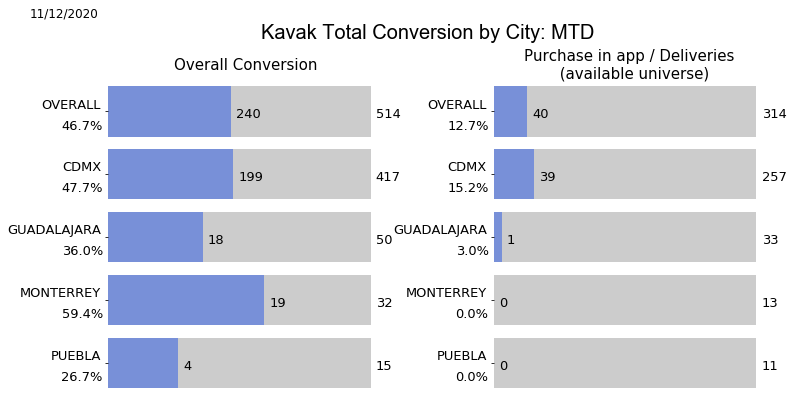

In [148]:
# GRAPH 3: CITIES MTD
# plot figure
fig6, (ax61, ax62) = plt.subplots(1, 2, sharex=True)
fig6.set_figwidth(10)
fig6.set_figheight(5)
fig6.tight_layout()
fig6.subplots_adjust(top=1, wspace=.4)
### 1
bar61g = ax61.barh(x_ktot, [1] * len(x_ktot), alpha=.4, color="gray")
bar61 = ax61.barh(x_ktot, y_ktot_pr, alpha=.6, color="royalblue")
ax61.set_title('Overall Conversion', fontsize=15, va='center')
ax61.set_yticklabels(x_ktot, va='bottom', fontsize=13)
### 2 
bar62g = ax62.barh(x_ktot_ntikc, [1] * len(x_ktot_ntikc), alpha=.4, color="gray")
bar62 = ax62.barh(x_ktot_ntikc, y_ktot_ntikc_pr, alpha=.6, color="royalblue")
ax62.set_title('Purchase in app / Deliveries \n (available universe)', fontsize=15, va='center')
ax62.set_yticklabels(x_ktot_ntikc, va='bottom', fontsize=13)
# format axes, title, and labels
### axes
sides = ['right', 'top', 'left', 'bottom']
for i in sides:
    ax61.spines[i].set_visible(False)
    ax62.spines[i].set_visible(False)
ax61.set_xticks([])
ax62.set_xticks([])
### title
titlestr = ('Kavak Total Conversion by City: MTD')
fig6.suptitle(titlestr, fontsize=20, fontname="Arial", va='bottom', y=1.08);
### labels 1
for idx,rect in enumerate(bar61):
    if (y_ktot[idx] != 0):
        ax61.text(y_ktot_pr[idx]+.02, rect.get_y()+.35,
            int(y_ktot[idx]), fontsize=13,
            ha='left', va='center', rotation=0)
    if (((y_entr[idx]-y_ktot[idx]) != 0) or (y_entr[idx]==0)):
        ax61.text(1+.02, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=13,
            ha='left', va='center', rotation=0)
    ax61.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_pr[idx]), fontsize=13,
            ha='right', va='center', rotation=0)
### labels 2
for idx,rect in enumerate(bar62):
    if (y_ktot[idx] != 0):
        ax62.text(y_ktot_ntikc_pr[idx]+.02, rect.get_y()+.35,
            int(y_ktot_ntikc[idx]), fontsize=13,
            ha='left', va='center', rotation=0)
    if (((y_enoti_nkcap[idx]-y_ktot_ntikc[idx]) != 0) or (y_enoti_nkcap[idx]==0)):
        ax62.text(1+.02, rect.get_y()+.35,
            int(y_enoti_nkcap[idx]), fontsize=13,
            ha='left', va='center', rotation=0)
    ax62.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_ntikc_pr[idx]), fontsize=13,
            ha='right', va='center', rotation=0)
### add timestamp
ax61.text(-.3, 5.5, hoy.strftime('%d/%m/%Y'), fontsize=12)
# save fig
plt.savefig('city_performance_mtd.png', bbox_inches = 'tight') 

In [23]:
# GRAPH 4: MTD (kcap + earth sales only)
### exclude tradeins
df_noti = df_curm[df_curm['tradein']==0]
### initialize dic
perf_hubs_piso = {}
perf_hubs_kcap = {}
count_piso = {}
count_kcap = {}
### find number of deliveries, ktotal
for hub, frame in df_noti.groupby(['hub']):
    entr = float(len(frame))
    perf_hubs_piso[hub] = float(len(frame[(frame['ktotal']==1) & (frame['kcapital']==0)]))/entr
    perf_hubs_kcap[hub] = float(len(frame[(frame['ktotal']==1) & (frame['kcapital']==1)]))/entr
    count_piso[hub] = len(frame[(frame['ktotal']==1) & (frame['kcapital']==0)])
    count_kcap[hub] = len(frame[(frame['ktotal']==1) & (frame['kcapital']==1)])
### set x and y values: ktotal 
if ('Sin asignar' in perf_hubs_kcap.keys()):
    perf_hubs_kcap.pop('Sin asignar')
if ('Sin asignar' in perf_hubs_piso.keys()):
    perf_hubs_piso.pop('Sin asignar') 
if ('Sin asignar' in count_piso.keys()):
    count_piso.pop('Sin asignar') 
if ('Sin asignar' in count_kcap.keys()):
    count_kcap.pop('Sin asignar') 

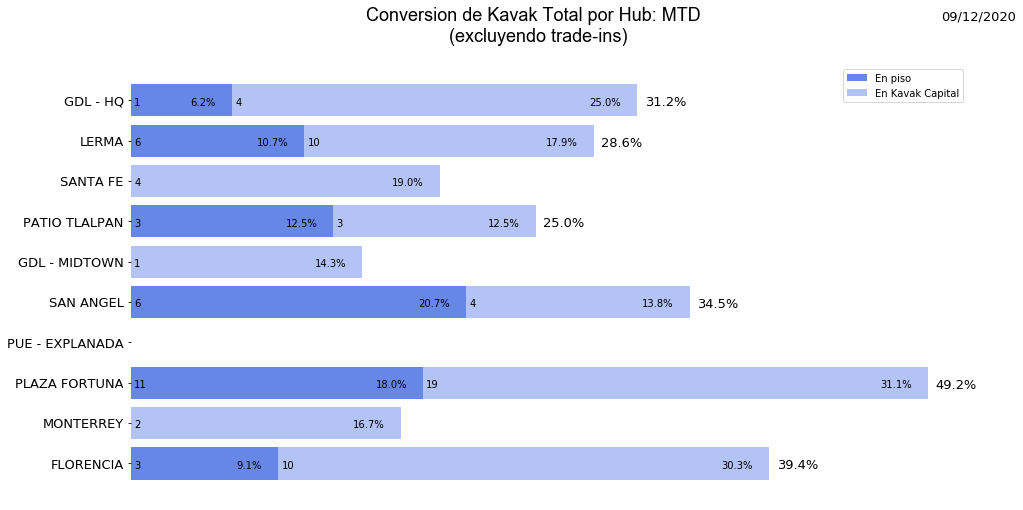

In [113]:
# GRAPH 4: MTD (kcap + earth sales only)
# plot bar graph
plt.rc('ytick', labelsize=13) 
fig3, ax31 = plt.subplots(1,1)
fig3.set_figheight(8)
fig3.set_figwidth(15)
bar31 = ax31.barh(perf_hubs_piso.keys(), perf_hubs_piso.values(), alpha=.8, color="royalblue",
                 label='En piso')
bar32 = ax31.barh(perf_hubs_kcap.keys(), perf_hubs_kcap.values(), alpha=.4, color="royalblue", 
                  left=perf_hubs_piso.values(), label='En Kavak Capital')
# format axes, title, and labels
### axes
for i in sides:
    ax31.spines[i].set_visible(False)
ax31.set_xticks([])
### title
titlestr = ('Conversion de Kavak Total por Hub: MTD \n (excluyendo trade-ins)')
fig3.suptitle(titlestr, fontsize=18, fontname="Arial", va='top')
### labels
##### 1
for idx,rect in enumerate(bar31):
    if (count_piso.values()[idx] != 0):
        ax31.text(rect.get_x()+.002, rect.get_y()+.35,
              count_piso.values()[idx], fontsize=10,
              ha='left', va='center', rotation=0)
    if (perf_hubs_piso.values()[idx] != 0):
        ax31.text(perf_hubs_piso.values()[idx]-.01, rect.get_y()+.35,
            "{:.1%}".format(perf_hubs_piso.values()[idx]), fontsize=10,
            ha='right', va='center', rotation=0)
for idx,rect in enumerate(bar32):
    if (count_kcap.values()[idx] != 0):
        ax31.text(rect.get_x()+.002, rect.get_y()+.35,
              count_kcap.values()[idx], fontsize=10,
              ha='left', va='center', rotation=0)
    if (perf_hubs_kcap.values()[idx] != 0):
        ax31.text(perf_hubs_piso.values()[idx]+perf_hubs_kcap.values()[idx]-.01, rect.get_y()+.35,
            "{:.1%}".format(perf_hubs_kcap.values()[idx]), fontsize=10,
            ha='right', va='center', rotation=0)
    if ((perf_hubs_kcap.values()[idx] != 0)&(perf_hubs_piso.values()[idx] != 0)):
        ax31.text(perf_hubs_piso.values()[idx]+perf_hubs_kcap.values()[idx]+.03, rect.get_y()+.35,
            "{:.1%}".format(perf_hubs_piso.values()[idx]+perf_hubs_kcap.values()[idx]), fontsize=13,
            ha='right', va='center', rotation=0)
    
### add legend
ax31.legend()
### add timestamp
hoy = datetime.date(datetime.now())
ax31.text(.5, 11, hoy.strftime('%d/%m/%Y'), fontsize=13);
### save plot
plt.savefig('hubs_mtd.png') 

In [154]:
# GRAPH 5: % ORGANIC CONTRACT SALES VINTAGE PLOT
### initialize dics
meses = ['11-2019', '12-2019', '1-2020', '2-2020', '3-2020', '4-2020', '5-2020', '6-2020',
         '7-2020', '8-2020', '9-2020', '10-2020', '11-2020', '12-2020']
growth_month = OrderedDict()
for i in meses:
    growth_month[i] = [0] * 92
ktot = OrderedDict()    
for i in meses:
    ktot[i] = 0
count_org = OrderedDict()    
for i in meses:
    count_org[i] = 0
perc_org = OrderedDict()    
for i in meses:
    perc_org[i] = 0
### calculate conversion over time
for month, frame in df_entregas.groupby(['month_yr']):
    frame_org = frame[(frame['ktotal']==1) & (frame['tradein']==0)]
    frame_ktot = frame[(frame['ktotal']==1)]
    counts = [0] * 92
    org = 0
    for i in range(len(frame_org)):
        diff = ((frame_org['ktotal_activation'].iloc[i]) - datetime.date(frame_org['date_delivery'].iloc[i])).days
        if(diff <= 0): continue
        if(diff > 0): org = org + 1
        if(diff > 91): counts[91] = counts[91]+1
        else: counts[diff] = counts[diff] + 1
    ktot[month] = len(frame_ktot)
    growth_month[month] = counts
    count_org[month] = org
    perc_org[month] = float(org)/float(len(frame_ktot))*100

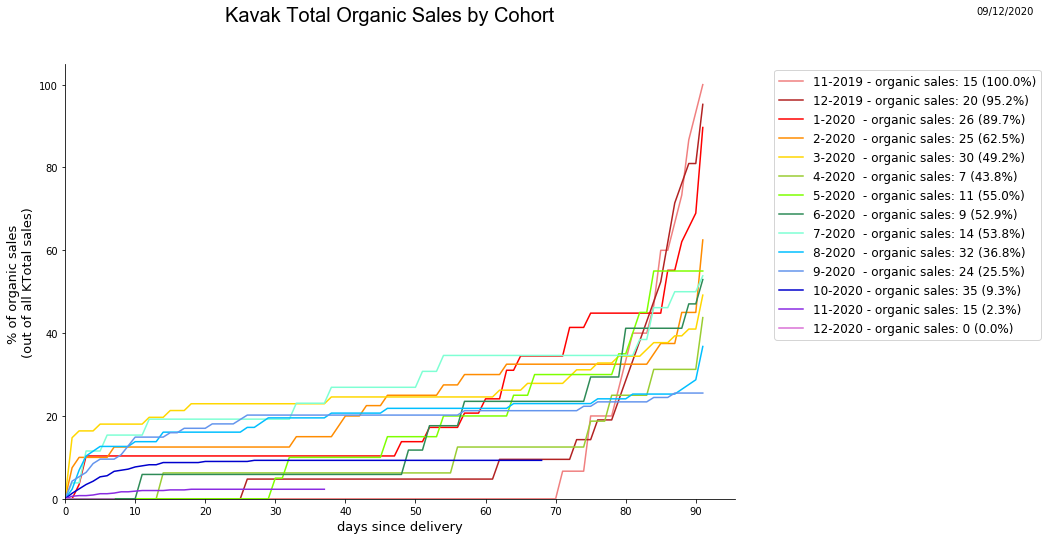

In [211]:
# GRAPH 5: ORGANIC CONTRACT SALES VINTAGE PLOT
# cut lines for conversions < 3 months
hoy = pd.to_datetime(datetime.date(datetime.now()))
for i in meses:
    d1 = datetime.strptime(i, "%m-%Y")
    dif = (hoy - d1).days
    if(dif<91):
        growth_month[i] = growth_month[i][:dif]
# plot graph and labels
plt.rc('ytick', labelsize=10) 
fig4, ax41  = plt.subplots(1,1, sharey=True)
fig4.set_figheight(8)
fig4.set_figwidth(12)
colors = ['lightcoral', 'firebrick', 'red', 'darkorange', 
         'gold', 'yellowgreen', 'chartreuse', 'seagreen', 
         'aquamarine', 'deepskyblue', 'cornflowerblue',
          'mediumblue', 'blueviolet', 'orchid']
count_color = 0
for i in meses:
    ax41.plot(range(len(growth_month[i])), (np.cumsum(growth_month[i])/float(ktot[i]))*100, 
                  label="{:<7} - organic sales: {} ({:.1f}%)".format(i, count_org[i], perc_org[i]),
              color=colors[count_color])
    #ax41.text(len(growth_month[i])+.5, perc_org[i], count_org[i],
     #             fontsize=11, ha='left', va='center', rotation=0)
    count_color = count_color+1
# format axes, legend, and title
### axes and legend
ax41.spines['right'].set_visible(False)
ax41.spines['top'].set_visible(False)
ax41.set_xticks(range(0, 92, 10))
ax41.set_xlabel('days since delivery', fontsize=13) 
ax41.set_xlim(left=0)
ax41.set_ylim(bottom=0)
ax41.legend(loc=2, bbox_to_anchor=(1.05, 1),  prop={'size': 12})
ax41.set_ylabel('% of organic sales \n(out of all KTotal sales)', fontsize=13) 
### title
titlestr = ('Kavak Total Organic Sales by Cohort')
fig4.suptitle(titlestr, fontsize=20, fontname="Arial", va='top') 
### add timestamp
hoy = datetime.date(datetime.now())
ax41.text(130, 117, hoy.strftime('%d/%m/%Y'), fontsize=10)
### save plot
plt.savefig('org_sales_cohorts.png', bbox_inches = 'tight') 

In [195]:
# GRAPH 6: ORGANIC CONVERSION VINTAGE PLOT
### initialize dics
univ = OrderedDict()    
for i in meses:
    univ[i] = 0
perc_org_conv = OrderedDict()    
for i in meses:
    perc_org_conv[i] = 0
### find available universe in each cohort
for month, frame in df_entregas.groupby(['month_yr']):
    univ[month] = len(frame[frame['ktotal']==0]) + count_org[month]
    perc_org_conv[month] = float(count_org[month])/float(univ[month])*100

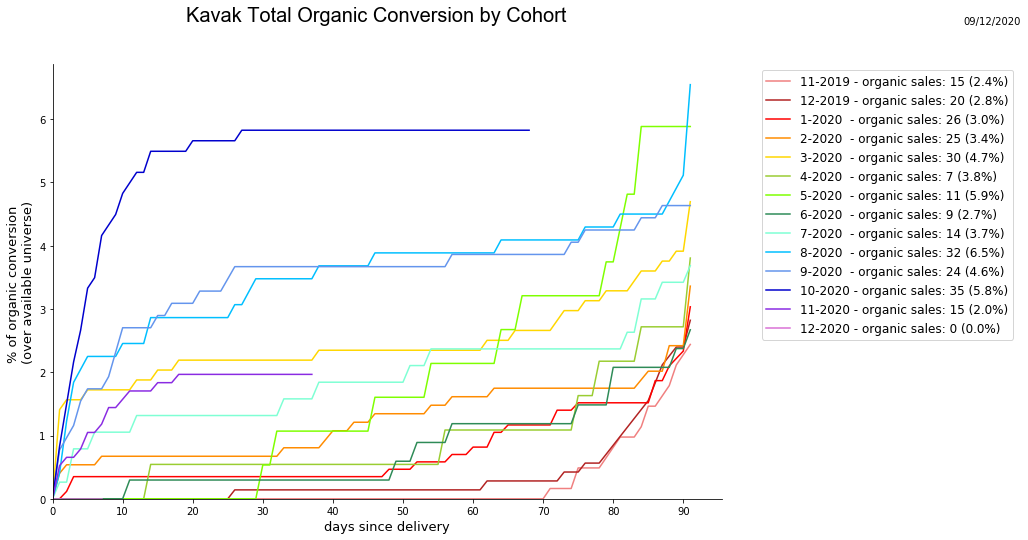

In [212]:
# GRAPH 6: ORGANIC CONVERSION VINTAGE PLOT
# plot graph and labels
fig5, ax51  = plt.subplots(1,1, sharey=True)
fig5.set_figheight(8)
fig5.set_figwidth(12)
count_color = 0
for i in meses:
    ax51.plot(range(len(growth_month[i])), (np.cumsum(growth_month[i])/float(univ[i]))*100,
              label="{:<7} - organic sales: {} ({:.1f}%)".format(i, count_org[i], perc_org_conv[i]),
              color=colors[count_color])
    count_color = count_color+1
# format axes, legend, and title
### axes and legend
ax51.spines['right'].set_visible(False)
ax51.spines['top'].set_visible(False)
ax51.set_xticks(range(0, 92, 10))
ax51.set_xlabel('days since delivery', fontsize=13) 
ax51.set_xlim(left=0)
ax51.set_ylim(bottom=0)
ax51.legend(loc=2, bbox_to_anchor=(1.05, 1), prop={'size': 12})
ax51.set_ylabel('% of organic conversion \n(over available universe)', fontsize=13) 
### title
titlestr_conv = ('Kavak Total Organic Conversion by Cohort')
fig5.suptitle(titlestr_conv, fontsize=20, fontname="Arial", va='top') 
### add timestamp
ax51.text(130, 7.5, hoy.strftime('%d/%m/%Y'), fontsize=10)
### save plot
plt.savefig('org_conv_cohorts.png', bbox_inches = 'tight') 

In [51]:
# EXPLORATORY ANALISIS: DELIVERIES PER HOUR
### find curr day, month, and year
curr_day = datetime.date(datetime.now()).day
curr_month = datetime.date(datetime.now()).month
curr_year = datetime.date(datetime.now()).year
print("Promedio de entregas por hora MTD (" + str(curr_day) + "-" + str(curr_month) + "-" + str(curr_year) + ")")
print("\n")
### filter data by curr month + year
df_month = df_entregas[(df_entregas['date_delivery'].dt.month == curr_month) &
                      (df_entregas['date_delivery'].dt.year == curr_year) &
                      (df_entregas['date_delivery'].dt.day <= curr_day)]
### create day col
df_month['day'] = df_month['date_delivery'].dt.day
### find hourly delivery averages for each hub
for hub, frame in df_month.groupby(['hub']):
    if(hub=='Sin asignar'): continue
    print(hub)
    for hour, frame_hour in frame.groupby(['hour']):
        sumh = float(len(frame_hour))
        days = float(len(set(frame_hour['day'])))
        avg = round(float(sumh/days), 2)
        if(avg != 1): print(hour + ": " + str(avg)) 
        else: continue
    print("\n")

Promedio de entregas por hora MTD (7-12-2020)


FLORENCIA
12:00: 1.5
13:30: 1.5
14:00: 2.0
16:00: 1.33
19:15: 2.0


GDL - HQ
15:00: 1.5
15:30: 2.0


GDL - MIDTOWN


LERMA
10:00: 1.67
11:00: 1.5
12:00: 2.0
14:00: 2.33
15:00: 2.0
16:30: 1.5
17:00: 1.5
18:00: 1.33


MONTERREY
12:00: 1.5
16:00: 2.0
17:30: 2.0


PATIO TLALPAN
14:00: 2.0
16:00: 1.5
16:15: 2.0


PLAZA FORTUNA
10:00: 1.5
12:00: 1.25
15:00: 1.2
16:00: 1.67
16:30: 2.0
17:00: 2.0
18:00: 1.33


PUE - EXPLANADA
10:00: 2.0


SAN ANGEL
14:00: 3.0
17:00: 2.0
18:00: 1.5


SANTA FE
13:00: 1.33
16:00: 1.5
17:00: 2.0




/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
